In [17]:
#Classical Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

#Importation of the model libraries


# Tools'libraries

from joblib import dump, load

## Model Selection and explanations

As we have seen, before train some models, we have done some pre-modeling : interpretability methods that we use before selecting and developing our models. This has allow us to reduce de dimensionality of the problem.

With this new dataset, we have train models chosen on two purpose :
- Random Forest for is explainability : it's an in-model : by nature interpretable
- ANN for is modeling capacity. But this is a black box model thus it's a post-model (post-Hoc) : need interpretability techniques that try to enhance model interpretability after the model has been developed

We will proceed as follows :
- 1. Self interpret the predictions made by our models. We mean have a look to the result, try to find some pattern and have an idea about how data are distributed in the predictions
- 2. Do some local interpretability : on the results of the first step, if we have find some "cluster" describing the results, we will apply local methods on it
- 3. Practice global interpretability : we want to have an overall description of different models

We are going to use library like Lime, Shap or Yellowbrick.

[lien] https://towardsdatascience.com/understanding-machine-learning-interpretability-168fd7562a1a https://towardsdatascience.com/three-interpretability-methods-to-consider-when-developing-your-machine-learning-model-5bf368b47fac https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/

In [4]:
#import shap
from lime import lime_tabular as LT

In [18]:
%store -r X_train
%store -r X_test
%store -r t_inc
%store -r t_acc
columns = ["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth", "Acc", "Inc"]
%store -r predRFAcc
%store -r predRFInc
#Load the model
rfModInc = load('../src/RandomForestInc.joblib')
rfModAcc = load('../src/RandomForestAcc.joblib')

In [19]:
data =  np.insert(X_test ,4, predRFAcc, axis=1)
data =  np.insert(data ,5, predRFInc, axis=1)
df = pd.DataFrame(data, columns=columns)
df_UL =  pd.DataFrame(X_test, columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
df.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth,Acc,Inc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.039046,0.816348,-0.008681,-0.019751,0.435000,0.254000
std,0.980881,27.301057,0.996013,0.985193,0.496005,0.435515
min,-3.112101,-703.416024,-4.291311,-4.441651,0.000000,0.000000
25%,-0.689478,-0.013890,-0.554415,-0.627383,0.000000,0.000000
50%,-0.021169,0.775194,0.106784,0.030686,0.000000,0.000000
75%,0.647141,1.412784,0.693722,0.658971,1.000000,1.000000
max,3.069764,382.636420,2.528648,3.291228,1.000000,1.000000


In [20]:
%store -r data_mean
%store -r data_std

mean = [data_mean[0], data_mean[3]/data_mean[4], data_mean[5], data_mean[6],0, 0]
std = [data_std[0], data_std[3]/data_std[4], data_std[5], data_std[6],1, 1]

df_true = pd.DataFrame(df*std+mean, columns=columns)
df_true.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth,Acc,Inc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.786000,1.973353,3.865530,4.132356,0.435000,0.254000
std,11.741638,27.347839,0.798926,0.907781,0.496005,0.435515
min,18.000000,-703.465770,0.430330,0.057911,0.000000,0.000000
25%,47.000000,1.141692,3.427784,3.572470,0.000000,0.000000
50%,55.000000,1.932128,3.958148,4.178830,0.000000,0.000000
75%,63.000000,2.570810,4.428945,4.757747,1.000000,1.000000
max,92.000000,384.447699,5.900783,7.183172,1.000000,1.000000


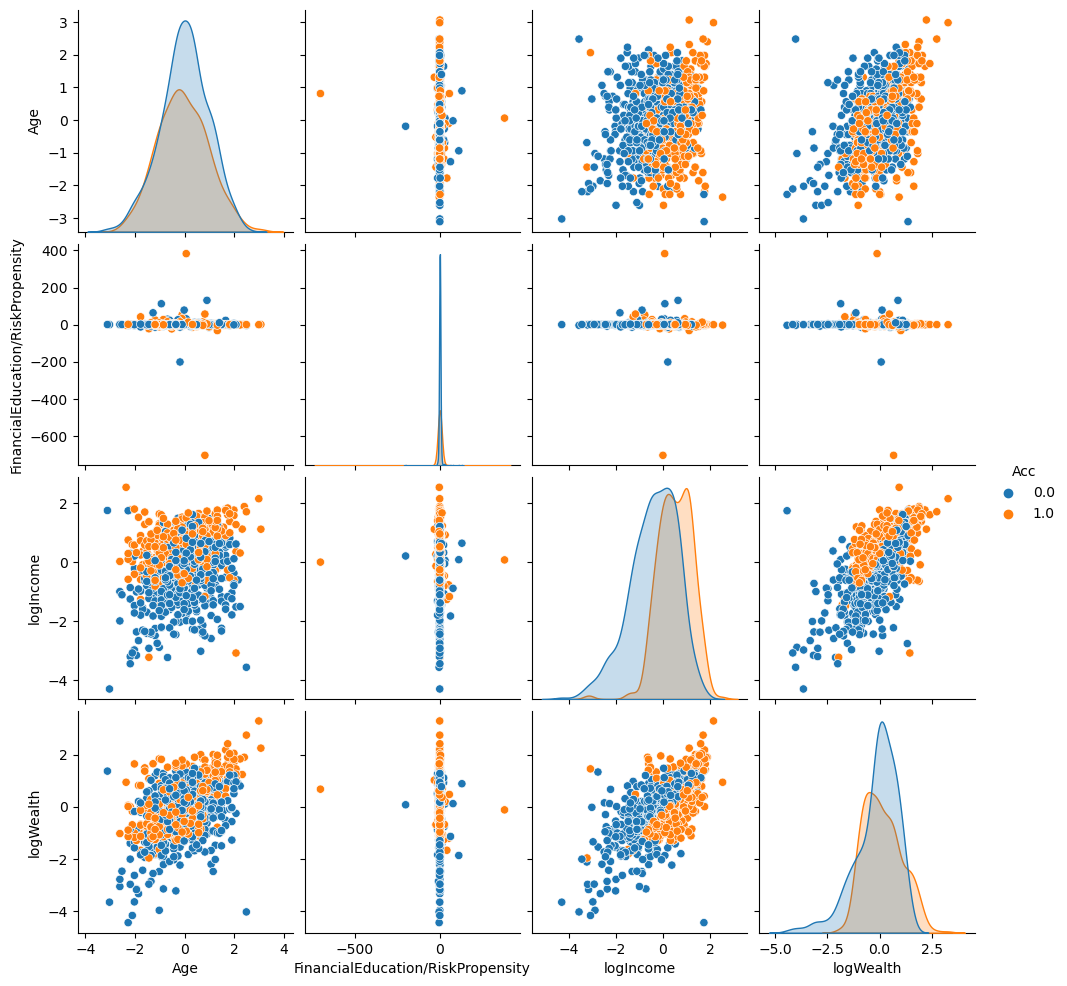

In [13]:
#Plot with the target IncomeInvestment
sns.pairplot(df[["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth","Acc"]], hue="Acc", data=df)

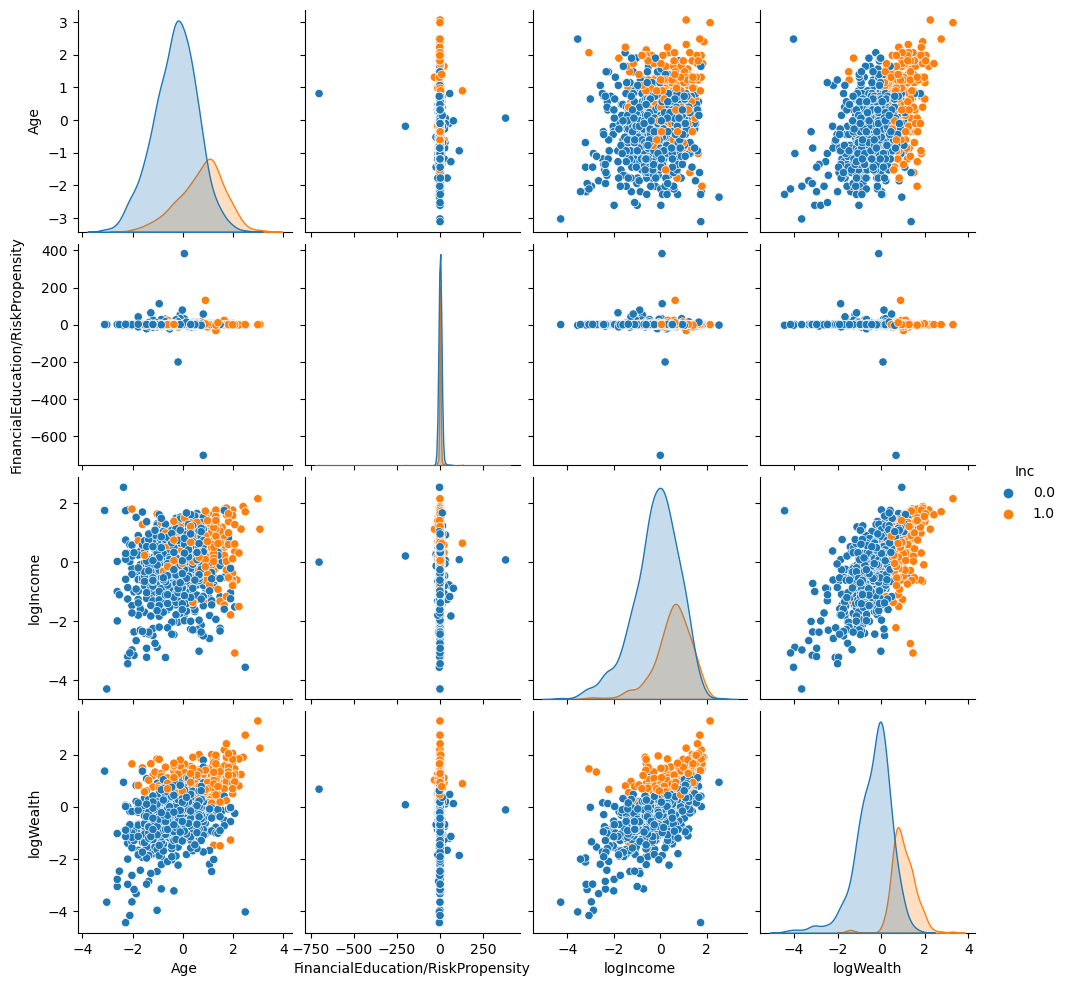

In [14]:
#Plot with the target IncomeInvestment
sns.pairplot(df[["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth","Inc"]], hue="Inc", data=df)

In [21]:
UL_test = df_UL.values
UL = df.values

Acc_true  = UL_test[(UL[:,4]==1)]
Acc_false = UL_test[(UL[:,4]==0)]

Inc_true  = UL_test[(UL[:,5]==1)]
Inc_false = UL_test[(UL[:,5]==0)]



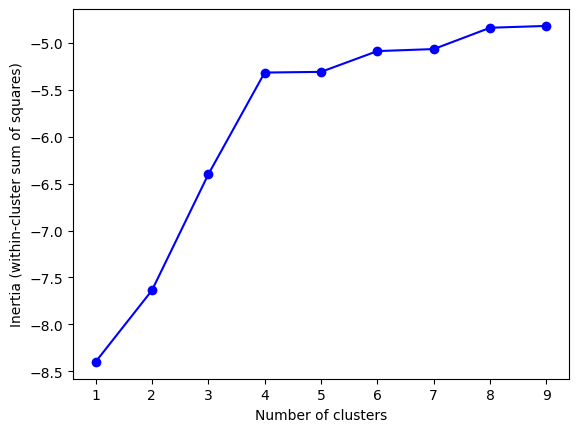

In [22]:
#lets train gaussian mixture to see some cluster
#let's see if there is some cluster inside

from sklearn.mixture import GaussianMixture as GM

gm = range(1, 10)
inertia = [GM(i).fit(Acc_true).lower_bound_ for i in gm]

fig = plt.figure()
plt.plot(gm, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.show()


[0.88186192 0.001      0.11613808 0.001     ]
[[  54.92091124    1.86109634    3.86633532    4.12947775]
 [  65.         -703.46576968    3.8714162     4.77325604]
 [  53.66318922    5.60660931    3.85880126    4.14947836]
 [  56.          384.44769946    3.93114338    4.04159072]]
classes [0 1 2 3] distributed as : [385   1  48   1]


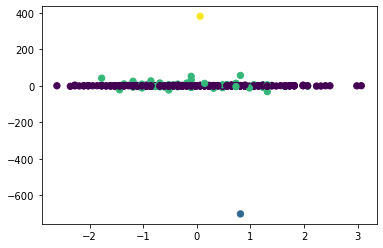

In [141]:
mixture = GM(4).fit(UL_test)
labels = mixture.predict(Acc_true)
print(mixture.weights_)
plt.scatter(Acc_true[:, 0], Acc_true[:, 1], c=labels, s=40)

print(mixture.means_*std[0:4] + mean[0:4])
a, count = np.unique(labels, return_counts=True)
print("classes",a,"distributed as :", count)



Text(0, 0.5, 'Inertia (within-cluster sum of squares)')

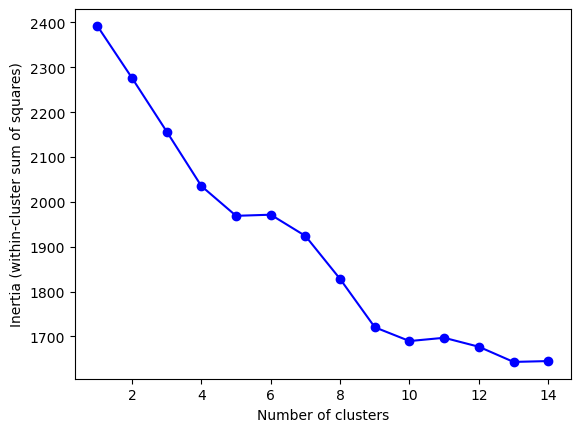

In [24]:
from sklearn_extra.cluster import KMedoids as KM


Km = range(1, 15)
inertia = [KM(i).fit(Acc_true).inertia_ for i in Km]

fig = plt.figure()
plt.plot(Km, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')

[[71.          2.88480128  4.65104662  5.29567803]
 [51.          0.31878009  4.13329511  4.08940645]
 [49.          2.38619807  3.94822049  3.97979394]
 [61.          1.87768428  4.59058713  4.56561126]
 [49.          1.84451166  4.38241172  4.84117527]
 [66.          1.67155543  3.9429569   4.69701509]
 [59.         -4.41255449  3.64487724  4.12280973]
 [47.          1.83829343  3.32491299  3.19880072]
 [57.         12.02348934  4.20659151  4.67297979]
 [65.          1.84176875  3.24180805  3.7583041 ]]
classes [0 1 2 3 4 5 6 7 8 9] distributed as : [60 70 91 55 36 24 24 44 19 12]


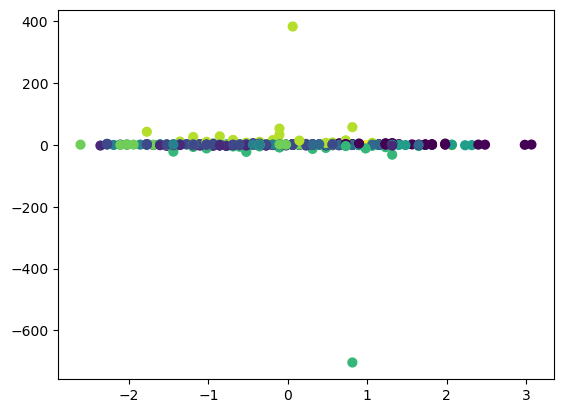

In [55]:
mixture = KM(10).fit(UL_test)
labels = mixture.predict(Acc_true)
plt.scatter(Acc_true[:, 0], Acc_true[:, 1], c=labels, s=40)

print(mixture.cluster_centers_*std[0:4] + mean[0:4])
a, count = np.unique(labels, return_counts=True)
print("classes",a,"distributed as :", count)

In [60]:
first = Acc_true[labels[:]==0]
tty = pd.DataFrame(first*std[0:4] + mean[0:4], columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
tty.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth
count,60.000000,60.000000,60.000000,60.000000
mean,68.933333,3.131831,4.745010,5.392748
std,8.550680,1.404973,0.494298,0.622705
min,52.000000,0.670778,3.382266,4.102450
25%,63.000000,2.132974,4.612903,4.864535
50%,69.000000,2.708741,4.805110,5.407265
75%,75.250000,3.743147,5.103396,5.844091
max,92.000000,6.449044,5.591129,7.183172


Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

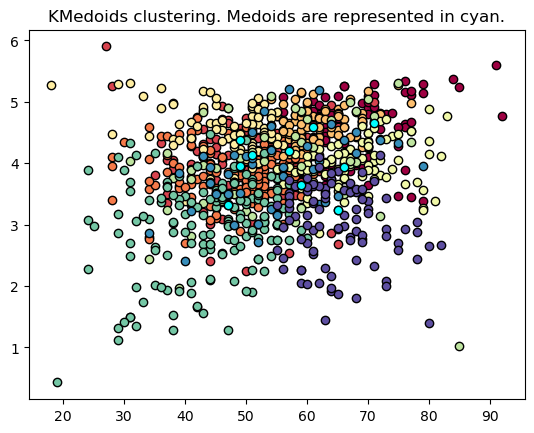

In [36]:
labels = mixture.labels_
cluster = mixture.cluster_centers_*std[0:4] + mean[0:4],
i, j = 0,2
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = UL_test[class_member_mask]
    plt.plot(
        xy[:, i]*std[i] + mean[i],
        xy[:, j]*std[j] + mean[j],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    mixture.cluster_centers_[:, i]*std[i] + mean[i],
    mixture.cluster_centers_[:, j]*std[j] + mean[j],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

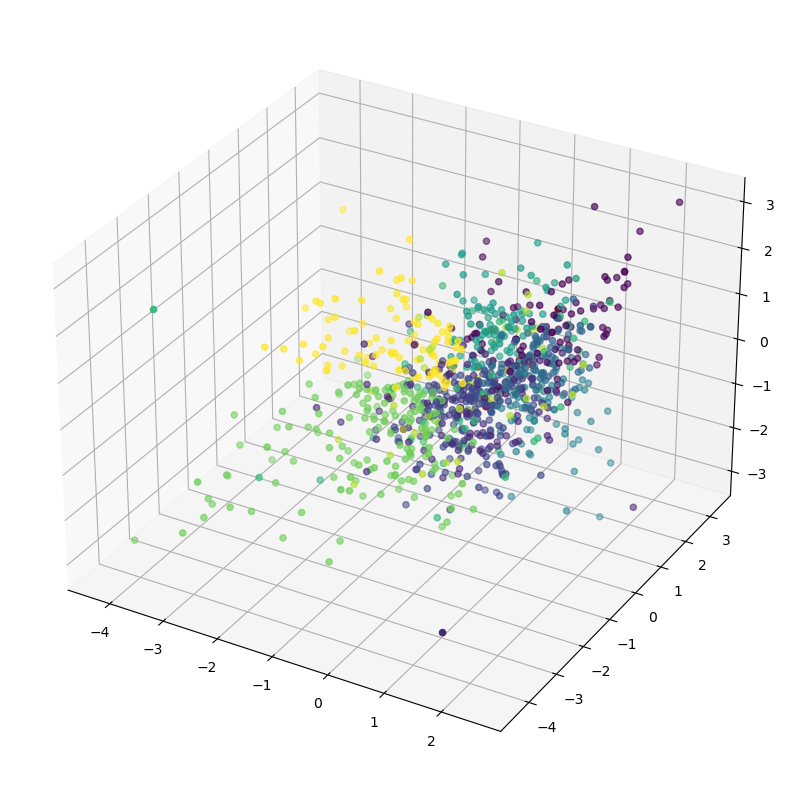

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["logIncome"], df["logWealth"],df["Age"], c=labels ) 
ax.scatter(mixture.cluster_centers_[:,2], mixture.cluster_centers_[:,3],mixture.cluster_centers_[:,0], c="r" ) 

plt.show()
